In [1]:
import datetime as dt
import warnings

import numpy as np
import pandas as pd
from scipy import signal
from scipy.signal import find_peaks
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.mixture import GaussianMixture

#--- Need Plotly for plotting-------------
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

In [2]:
STARTDATE='20000101 00:00'

def addingStandardDatetimeIndex(df):
    x = pd.Timestamp(STARTDATE) + \
        pd.to_timedelta(np.arange(df.shape[1]),unit='m')
    df.columns = [ str(i.time())[:-3] for i in x]
    df.index = pd.to_datetime(pd.Timestamp(STARTDATE) + \
        pd.to_timedelta(np.arange(df.shape[0]),unit='d'))
    

    return df

def addingDurationofSleep(sleep):
    sleep = sleep.apply( pd.to_numeric )
    sleep['extraTimefornextDay'] = 1
    for index ,_ in sleep.iterrows():
        sleep.loc[index, 'extraTimefornextDay'] = \
            sleep.loc[index].values[::-1].cumprod().sum()
    sleep['extraTimefornextDay'][sleep['extraTimefornextDay']==1]=0
    sleep['duration'] = sleep.loc[:,'00:00':'23:59'].sum(axis=1) + \
        sleep['extraTimefornextDay'].shift(1)
    return sleep

def addingTimetoSleep(sleep):
    sleep['timeToSleep']= 0

    for index ,_ in sleep.iterrows():
        try:
            if sleep.loc[index,'00:00':'23:59'].astype(int).idxmax() =='00:00':
                prev_index= index -pd.to_timedelta(1,unit='d')
                if sleep.loc[prev_index , 'extraTimefornextDay'] ==0:
                    
                    sleep.loc[index, 'timeToSleep'] = (dt.datetime.combine(dt.date.today(),
                                                                            dt.datetime.strptime(sleep.loc[index,'00:00':'23:59'].astype(int).idxmax(),
                                                                                                 '%H:%M').time())\
                                                                                - dt.datetime.combine(dt.date.today() , dt.time(0,0))).total_seconds()/60
                else:
                    
                    minutesBefore12 = sleep.loc[prev_index , 'extraTimefornextDay']
                    prevTimetoSleep= dt.datetime.combine(dt.date.today(), dt.time(0,0)) - dt.timedelta(minutes=int(minutesBefore12))
                    sleep.loc[index, 'timeToSleep'] = -(dt.datetime.combine(dt.date.today(),  dt.time(0,0)) - \
                        prevTimetoSleep).total_seconds()/(60)
                        
            else:
                sleep.loc[index, 'timeToSleep'] = \
                    (dt.datetime.combine(dt.date.today(),dt.datetime.strptime(sleep.loc[index,'00:00':'23:59'].astype(int).idxmax(),
                                                                              '%H:%M').time())- dt.datetime.combine(dt.date.today() ,
                                                                                                                    dt.time(0,0))).total_seconds()/60

        except:pass
    return sleep.fillna(0)

def to_numeric(df):
    for i in df.columns:
        try:
            df[[i]] = df[[i]].astype(float).astype(int)
        except:
            pass
    return df

def addSeasontodataFrame(df):
    df['year'] = [d.year for d in df.index]
    df['month'] = [d.strftime('%b') for d in df.index]
    df['dayofweek'] = [d.strftime('%A') for d in df.index]
    season_dict = {'Jan': 'Winter',
               'Feb': 'Winter',
               'Mar': 'Spring', 
               'Apr': 'Spring',
               'May': 'Spring',
               'Jun': 'Summer',
               'Jul': 'Summer',
               'Aug': 'Summer',
               'Sep': 'Fall',
               'Oct': 'Fall',
               'Nov': 'Fall',
               'Dec': 'Winter'}
    df['Season'] = df.month.apply(lambda x: season_dict[x])
    return df

def addFeaturestoSleep(df):
    sleep= addingStandardDatetimeIndex(df)
    sleep = addingDurationofSleep(sleep)
    sleep= addingTimetoSleep(sleep)
    # del sleep['extraTimefornextDay']
    return sleep

def addFeaturestoSteps(df):
    steps = addingStandardDatetimeIndex(df)
    # steps['sumSteps'] = steps.sum(axis=1)
    return steps


def makeboxplots(df,respect_to):
    fig, axes = plt.subplots(1, 4, figsize=(30,7), dpi= 80)


    # df['year'] = [d.year for d in df.index]
    # df['month'] = [d.strftime('%b') for d in df.index]
    # df['dayofweek'] = [d.strftime('%A') for d in df.index]
    # df = addSeasontodataFrame(df)

    sns.boxplot(x='year', y=respect_to, data=df, ax=axes[0])
    sns.boxplot(x='month', y=respect_to, data=df , ax=axes[1])
    sns.boxplot(x='dayofweek', y=respect_to, data=df , ax=axes[2])
    sns.boxplot(x='Season', y=respect_to, data=df , ax=axes[3])

def findOutliers(df, respect_to, contamination=0.1, n_estimators=50):
    clf = IsolationForest(n_estimators=n_estimators, 
                          contamination=float(contamination),
                        max_samples='auto')
    clf.fit(df[[respect_to]])
    df['anomaly_IsolationForest_'+respect_to]=clf.predict(df[[respect_to]])
    df['anomaly_IsolationForest_'+respect_to] = np.where((df['anomaly_IsolationForest_'+respect_to]==-1), 1 ,0)
    if respect_to=='timeToSleep':
        df['anomaly_IsolationForest_'+respect_to][df['timeToSleep']< df['timeToSleep'].quantile(.50)]=0
    if respect_to=='duration':
        df['anomaly_IsolationForest_'+respect_to][df['duration']> df['duration'].quantile(.50)]=0
    return df

def findingSleepsfromSteps(date, h=2.5 , w=4, height=3 ,verbose=False,k=150):
    
    sleepBefore12= False
    stepsmean = steps.loc[date,'00:00':'23:59'].rolling(w).mean()
    dayofweek= df.loc[date, 'dayofweek']
    season = df.loc[date, 'Season']
    peaks, heights= find_peaks(stepsmean, height=height)
    # if len(peaks) == 0:
    #     plot_date(date)
    if steps.loc[date,'00:00':'23:59'].sum() ==0 or len(peaks) == 0:


        return 0,0

    stepsmean.iloc[~stepsmean.reset_index(drop=True).index.isin(peaks)]=0

    if peaks[0]>k:
        prev_date= date -pd.to_timedelta(1,unit='d')
        stepsmean_prev = steps.loc[prev_date,'00:00':'23:59'].rolling(2).mean()
        peaks_prev, heights_prev= find_peaks(stepsmean_prev, height=height)
        timeToSleep = peaks_prev[-1] - 1440
        peaks = [peaks_prev[-1] - 1440]+list(peaks)
        sleepBefore12= True


    newlist = [peaks[i+1] - peaks[i] for i in range(len(peaks) -1)]

    sleepDurations=[ x for x in newlist if x>h * 60]
    if len(sleepDurations)>0  and not sleepBefore12:
        timeToSleep= peaks[newlist.index(sleepDurations[0])]
        sumofsleeps_fromSteps = sum([ x for x in newlist if x>h * 60])
        
    elif len(sleepDurations)==0:

        sumofsleeps_fromSteps=0
        timeToSleep = 0
        
    elif sleepBefore12:
        sumofsleeps_fromSteps = sum([ x for x in newlist if x>h * 60])

    
    if timeToSleep > 500:
        timeToSleep =df['timeToSleep'][(df.dayofweek==dayofweek)&\
            (df.Season== season)].mean()
    if sumofsleeps_fromSteps < 100 or sumofsleeps_fromSteps>1000:
        sumofsleeps_fromSteps = df['duration'][(df.dayofweek==dayofweek)&\
            (df.Season== season)].mean()
        
    return sumofsleeps_fromSteps , timeToSleep

def findoutliers_seasonal_dayofweek_quantilemethod(df, respect_to, q=1.3):
    df['anomaly_seasonal_quantilemethod_'+respect_to]=0
    df['anomaly_'+respect_to]=0
    
    if respect_to=='duration':
        df['anomaly_seasonal_quantilemethod_'+respect_to][df[respect_to]< df[respect_to].mean() - q * df[respect_to].std() ]=1
    elif respect_to=='timeToSleep':
        df['anomaly_seasonal_quantilemethod_'+respect_to][df[respect_to]> df[respect_to].mean() +q * df[respect_to].std()]=1
    elif  respect_to=='duration_fromSteps':
        df['anomaly_'+respect_to][df[respect_to] < df[respect_to].mean() - q * df[respect_to].std()]=1
    elif  respect_to=='timeToSleep_fromSteps':
        df['anomaly_'+respect_to][df[respect_to] > df[respect_to].mean() +q * df[respect_to].std()]=1
    return df

def plot_date(date):
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        name="sleep",
        mode="lines", x=sleep.loc[date,'00:00':'23:59'].index, y=sleep.loc[date,'00:00':'23:59'].values,

    ))
    fig.add_trace(go.Scatter(
            name="steps",
        mode="lines", x=steps.loc[date,'00:00':'23:59'].index, y=steps.loc[date,'00:00':'23:59'].values,
        hovertemplate=len(steps.loc[date,'00:00':'23:59'])*[steps.loc[date,'00:00':'23:59'].name]
    ))
    fig.show()
    
def GettingSeasonalOutliers_fromSleepData(df, sleep):
    sleep_seasonal = addSeasontodataFrame(sleep)
    df['anomaly_seasonal_quantilemethod_duration']=0
    df['anomaly_seasonal_quantilemethod_timeToSleep']=0

    for season in sleep_seasonal.Season.unique():
        for dayofweek in sleep_seasonal.dayofweek.unique():
            cropped_df = sleep_seasonal[(sleep_seasonal.dayofweek==dayofweek)&\
                (sleep_seasonal.Season== season)]
            cropped_df = findoutliers_seasonal_dayofweek_quantilemethod(cropped_df, 'duration')

            
            df.loc[cropped_df.index, 'anomaly_seasonal_quantilemethod_duration']=cropped_df['anomaly_seasonal_quantilemethod_duration']
            cropped_df = findoutliers_seasonal_dayofweek_quantilemethod(cropped_df, 'timeToSleep')
    
            df.loc[cropped_df.index, 'anomaly_seasonal_quantilemethod_timeToSleep']=cropped_df['anomaly_seasonal_quantilemethod_timeToSleep']
    print('Getting Season-dayOfWeek-dependent Outliers added!-------')

    outliers_from_seasonal_dayofweek_timestamps=df[(df['anomaly_seasonal_quantilemethod_duration']==1)|
    (df['anomaly_seasonal_quantilemethod_timeToSleep']==1)].index
    print('Outliers from seasonal-dayOfWeek-dependent : \n\n',
          outliers_from_seasonal_dayofweek_timestamps)
    return outliers_from_seasonal_dayofweek_timestamps
    
def GettingSeasonalOutliers_fromStepsData(df, steps):
    df['duration_fromSteps']=0
    df['timeToSleep_fromSteps']=0

    for date in df.index:
        try:    
            sumofsleeps_fromSteps , timeToSleep_fromSteps= \
                findingSleepsfromSteps(date, h=2, w=4, height=7, k=150)
            df.loc[date, 'duration_fromSteps'] = sumofsleeps_fromSteps
            df.loc[date, 'timeToSleep_fromSteps'] = timeToSleep_fromSteps
        except Exception as e:
            df.loc[date, 'duration_fromSteps'] = 0
            df.loc[date, 'timeToSleep_fromSteps'] = 0
            continue
    sleep_seasonal = df.copy()
    df['anomaly_duration_fromSteps']=0
    df['anomaly_timeToSleep_fromSteps']=0

    for season in sleep_seasonal.Season.unique():
        for dayofweek in sleep_seasonal.dayofweek.unique():
            cropped_df = sleep_seasonal[(sleep_seasonal.dayofweek==dayofweek)&\
                (sleep_seasonal.Season== season)]
            cropped_df = findoutliers_seasonal_dayofweek_quantilemethod(cropped_df, 
                                                                        'duration_fromSteps',q=1.2)
            
            df.loc[cropped_df.index, 'anomaly_duration_fromSteps']=cropped_df['anomaly_duration_fromSteps']
            
            cropped_df = findoutliers_seasonal_dayofweek_quantilemethod(cropped_df, 
                                                                        'timeToSleep_fromSteps',q=1.2)
            
            df.loc[cropped_df.index, 'anomaly_timeToSleep_fromSteps']=cropped_df['anomaly_timeToSleep_fromSteps']
            
    df1=df[(df['anomaly_seasonal_quantilemethod_duration']==1)|
    (df['anomaly_seasonal_quantilemethod_timeToSleep']==1)]
    df2=df[(df['anomaly_duration_fromSteps']==1)|
    (df['anomaly_timeToSleep_fromSteps']==1)]


    print( '\n\n the number of mutual outliers between sleep data and steps data:',
        len([ x for x in df1.index if x  in df2.index]),
        '\n number of outliers in in sleep data: ' , len(df1.index),' average ',
        len(df1.index)/(len(df.index)/30), ' for each month --'
        '\n number of outlier found in steps data: ',len(df2.index),' average ',
        len(df2.index)/(len(df.index)/30), ' for each month --')
    
    

    print('\n\n Outliers from steps data : \n\n', df2.index)
    return df2.index


In [3]:
sleep= pd.DataFrame(np.load('sleep.npy'))
steps= pd.DataFrame(np.load('steps.npy'))
sleep = sleep.apply(pd.to_numeric)
steps = steps.apply(pd.to_numeric)
sleep[sleep>1]=1


In [4]:
sleep=addFeaturestoSleep(sleep)

steps = addFeaturestoSteps(steps)

In [5]:
df = sleep[['duration','timeToSleep']].copy()
df = addSeasontodataFrame(df)
df = findOutliers(df, 'duration', contamination=0.15)
df = findOutliers(df, 'timeToSleep', contamination=.15)

In [6]:
seasonalOutliersFromSleepdata= GettingSeasonalOutliers_fromSleepData(df, sleep)
# pd.DataFrame(seasonalOutliersFromSleepdata).to_csv('seasonalOutliersFromSleepdata.csv')

Getting Season-dayOfWeek-dependent Outliers added!-------
Outliers from seasonal-dayOfWeek-dependent : 

 DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2006-01-25', '2006-01-27', '2006-01-28', '2006-01-29',
               '2006-01-30', '2006-02-27', '2006-02-28', '2006-03-22',
               '2006-03-26', '2006-04-21'],
              dtype='datetime64[ns]', length=390, freq=None)


In [7]:
seasonalOutliersFromStepsdata= GettingSeasonalOutliers_fromStepsData(df, steps)
# pd.DataFrame(seasonalOutliersFromStepsdata).to_csv('seasonalOutliersFromStepsdata.csv')



 the number of mutual outliers between sleep data and steps data: 240 
 number of outliers in in sleep data:  390  average  5.080330004342162  for each month --
 number of outlier found in steps data:  382  average  4.976118106817195  for each month --


 Outliers from steps data : 

 DatetimeIndex(['2000-01-01', '2000-01-03', '2000-01-06', '2000-01-07',
               '2000-01-08', '2000-01-12', '2000-01-13', '2000-01-14',
               '2000-01-20', '2000-01-21',
               ...
               '2006-01-19', '2006-01-30', '2006-02-17', '2006-02-27',
               '2006-03-15', '2006-03-20', '2006-03-26', '2006-04-08',
               '2006-04-19', '2006-04-21'],
              dtype='datetime64[ns]', length=382, freq=None)


In [8]:
fig = px.histogram(df, x="duration",
                   marginal="box")
fig.show()

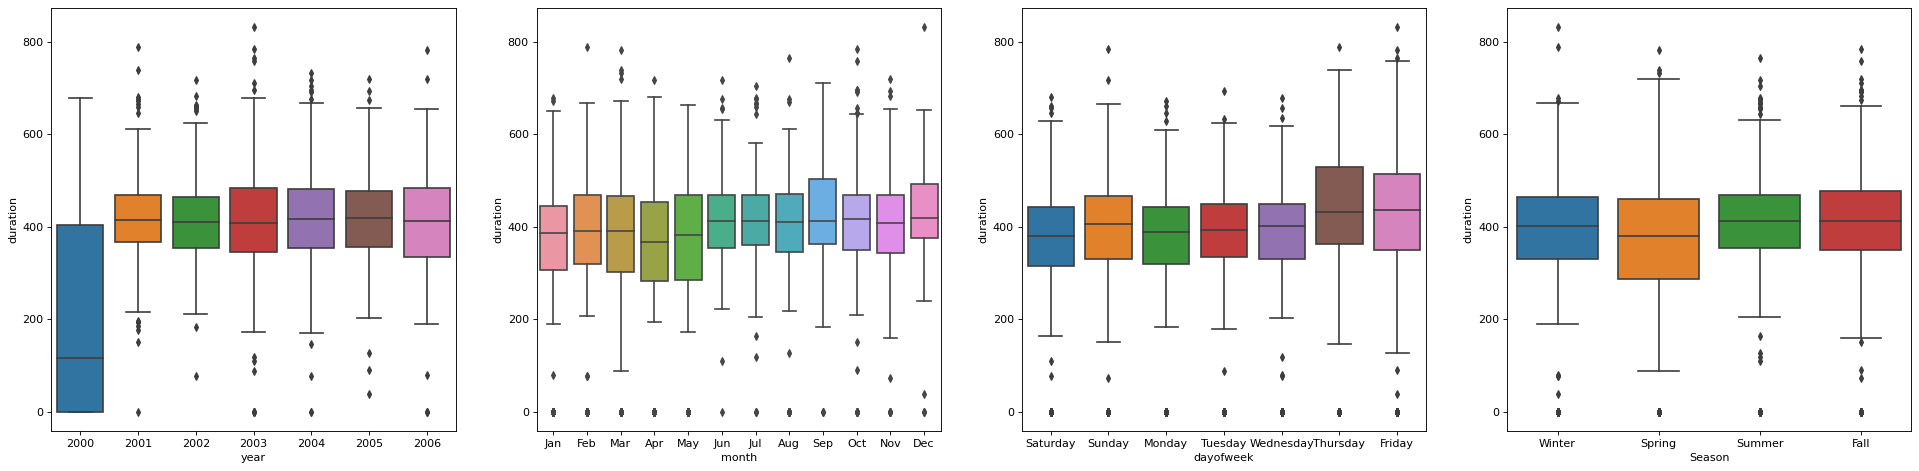

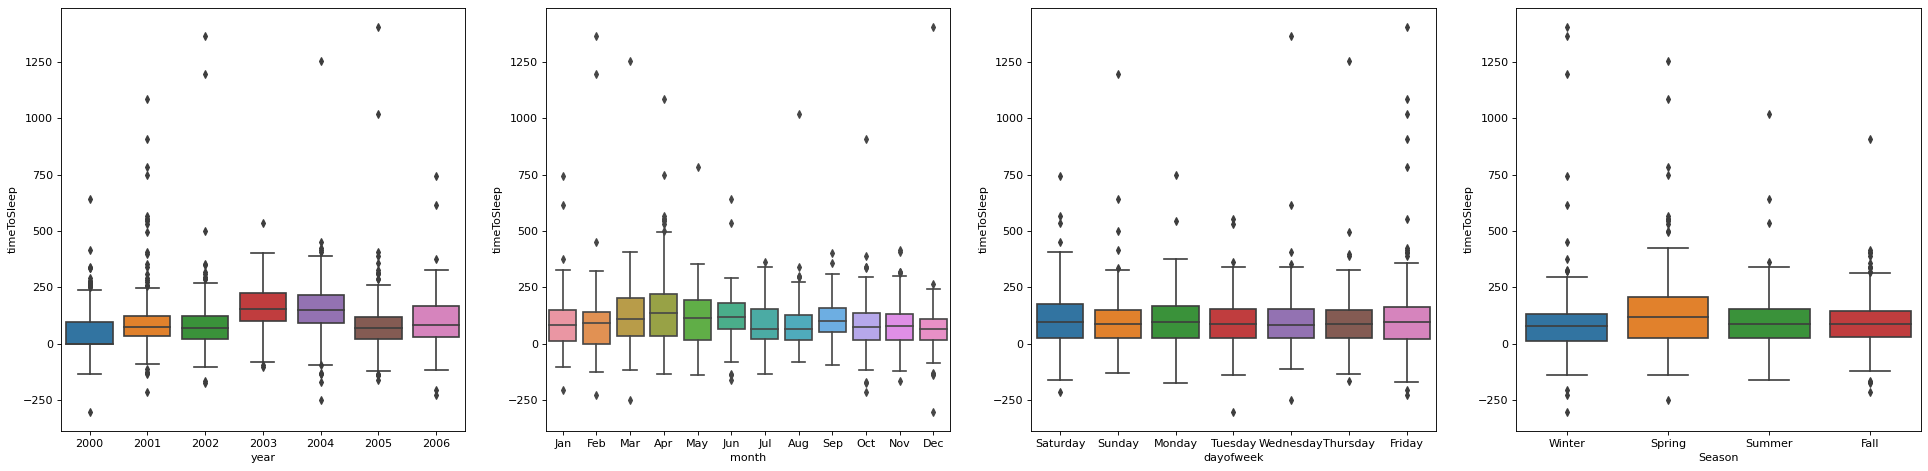

In [9]:
makeboxplots(df, respect_to='duration')
makeboxplots(df, respect_to='timeToSleep')

In [10]:
fig= px.violin(df, y='duration', x='Season', color='dayofweek',
          box=True, template='plotly_dark')
fig.show()
# fig.write_html("violin_plot.html")

In [11]:
df_season_dow = df.groupby([df.Season , df.dayofweek])['anomaly_seasonal_quantilemethod_duration'].sum()

px.bar(df_season_dow , x=df_season_dow.index.get_level_values(0),
           y=df_season_dow.values ,barmode='group',
           color= df_season_dow.index.get_level_values(1))

In [12]:
df_season_dow = df.groupby([df.year , df.month])['anomaly_seasonal_quantilemethod_timeToSleep'].sum()
px.bar(df_season_dow , x=df_season_dow.index.get_level_values(0),
           y=df_season_dow.values ,barmode='group',
           color= df_season_dow.index.get_level_values(1))

In [13]:
df_season_dow = df.groupby([df.year , df.month])['anomaly_seasonal_quantilemethod_duration'].sum()
px.bar(df_season_dow , x=df_season_dow.index.get_level_values(0),
           y=df_season_dow.values ,barmode='group',
           color= df_season_dow.index.get_level_values(1))

In [14]:
px.scatter(df, x=df.index , y=df.timeToSleep , 
           color=df['anomaly_seasonal_quantilemethod_timeToSleep'].map(lambda x: 'Outlier' if x==1 else 'Normal'),
           hover_data=['anomaly_seasonal_quantilemethod_timeToSleep'])

In [15]:
px.scatter(df, x=df.index , y=df.duration , 
           color=df['anomaly_seasonal_quantilemethod_duration'].map(lambda x: 'Outlier' if x==1 else 'Normal'),
           hover_data=['anomaly_seasonal_quantilemethod_duration'])


In [16]:
data= df[['timeToSleep','timeToSleep_fromSteps']].copy()
gmm = GaussianMixture(n_components=2)
gmm.fit(data)
labels = gmm.predict(data)
df['cluster'] = labels
px.scatter(df[(df['timeToSleep']!=0)&(df['timeToSleep_fromSteps']!=0)], x='timeToSleep_fromSteps',
           y='timeToSleep', 
           color=df['cluster'][(df['timeToSleep']!=0)&(df['timeToSleep_fromSteps']!=0)].map(lambda x: 'good' if x==1 else 'bad'),
           color_continuous_scale=px.colors.sequential.Viridis,
           hover_name=df[(df['timeToSleep']!=0)&(df['timeToSleep_fromSteps']!=0)].index)

In [17]:
data= df[['duration','duration_fromSteps']].copy()
gmm = GaussianMixture(n_components=2)
gmm.fit(data)
labels = gmm.predict(data)
df['cluster'] = labels
px.scatter(df, x='duration_fromSteps',
           y='duration', 
           color=df['cluster'].map(lambda x: 'good' if x==1 else 'bad'),
           color_continuous_scale=px.colors.sequential.Viridis,
           hover_name=df.index)

In [ ]:
px.scatter(df, x=df.index , y=df['duration_fromSteps'] , 
           color=df['anomaly_duration_fromSteps'].map(lambda x: 'Outlier' if x==1 else 'Normal'),
           hover_data=['anomaly_duration_fromSteps'])
#%%
px.scatter(df, x=df.index , y=df['timeToSleep_fromSteps'] , 
           color=df['anomaly_timeToSleep_fromSteps'].map(lambda x: 'Outlier' if x==1 else 'Normal'),
           hover_data=['anomaly_timeToSleep_fromSteps'])